# Overture Maps: Fetching Land Cover Data

This notebook demonstrates how to fetch **Land Cover** data from the **Overture Maps Foundation** dataset using **DuckDB**. We will filter the data to a specific Area of Interest (AOI) covering the Continental US, Hawaii, and Puerto Rico, and save it as a Parquet file for further analysis.

**Goal**: efficient retrieval of environmental context (e.g., cropland, scrubland) for solar farm analysis.

### 🛠️ Tools Used
- **DuckDB**: High-performance SQL OLAP database for querying remote Parquet files.
- **GeoPandas**: For visualizing and manipulating geospatial data.
- **Overture Maps**: Open map data source (S3 bucket).

### 📚 References
- [Overture Land Cover Schema](https://docs.overturemaps.org/schema/reference/base/land_cover/)
- [DuckDB Spatial Extension](https://duckdb.org/docs/extensions/spatial)

In [1]:
import duckdb
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Define Area of Interest (AOI)

We define a Bounding Box (BBOX) that covers:
- Continental USA
- Hawaii
- Puerto Rico

**BBOX Format**: `(min_x, min_y, max_x, max_y)`

In [2]:
# AOI: USA + HI + PR
# AOI_BBOX = (-160.25, 17.9, -65.2, 49.4)
AOI_BBOX = (-89.9190,24.7674,-76.7229,36.7593)
print(f"Area of Interest (BBOX): {AOI_BBOX}")

Area of Interest (BBOX): (-89.919, 24.7674, -76.7229, 36.7593)


## 2. Query Overture Maps with DuckDB

We use DuckDB to directly query the Overture Maps S3 bucket. We'll fetch data from the `base` theme, specifically the `land_cover` type.

**Note**: We are using a specific release version `2025-11-19.0` to ensure reproducibility.

In [3]:
# Overture S3 Path
OVERTURE_RELEASE = "2025-11-19.0"
S3_PATH = f"s3://overturemaps-us-west-2/release/{OVERTURE_RELEASE}/theme=base/type=land_cover/*"

# Output Filename
OUTPUT_PARQUET = "overture_land_cover_aoi.parquet"

print(f"Querying: {S3_PATH}")
print(f"Saving to: {OUTPUT_PARQUET}")

Querying: s3://overturemaps-us-west-2/release/2025-11-19.0/theme=base/type=land_cover/*
Saving to: overture_land_cover_aoi.parquet


In [4]:
# Initialize DuckDB connection
con = duckdb.connect()

# Install and Load Extensions
con.execute("INSTALL spatial; LOAD spatial;")
con.execute("INSTALL httpfs; LOAD httpfs;")

# Configure S3 (Overture bucket is public, so no creds needed, but region helps)
con.execute("SET s3_region='us-west-2';")

# Construct SQL Query
# We filter using the 'bbox' struct column in the Parquet files for efficiency
# Note: Overture bbox struct uses xmin, ymin, xmax, ymax
# Schema Note: land_cover has 'subtype' but not 'class' or 'names'
query = f"""
COPY (
    SELECT
        id,
        subtype,
        geometry
    FROM read_parquet('{S3_PATH}')
    WHERE
        bbox.xmin > {AOI_BBOX[0]} AND
        bbox.xmax < {AOI_BBOX[2]} AND
        bbox.ymin > {AOI_BBOX[1]} AND
        bbox.ymax < {AOI_BBOX[3]}
) TO '{OUTPUT_PARQUET}' (
    FORMAT PARQUET,
    COMPRESSION 'ZSTD',
    ROW_GROUP_SIZE 100000
);
"""

print("Executing Query... (This may take a minute)")
try:
    con.execute(query)
    print("✅ Data successfully fetched and saved to Parquet.")
except Exception as e:
    print(f"❌ Error: {e}")

Executing Query... (This may take a minute)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Data successfully fetched and saved to Parquet.


## 3. Visualization with GeoPandas

Now we load the local Parquet file into a GeoDataFrame to visualize the land cover types.

In [5]:
# Read the saved Parquet file
print(f"Reading {OUTPUT_PARQUET}...")
gdf = gpd.read_parquet(OUTPUT_PARQUET)

# Check the data
print(f"Loaded {len(gdf):,} rows.")
gdf.head()

Reading overture_land_cover_aoi.parquet...
Loaded 941,720 rows.


,id,subtype,geometry
0,0093f1ba-9f96-5cfc-99e2-1a92a547863c,shrub,"POLYGON ((-79.05921 36.75505, -79.05898 36.755..."
1,fea34560-c2c1-5d4c-ab3d-234904cc7ad8,crop,"POLYGON ((-79.07752 36.74147, -79.07724 36.741..."
2,87d65a04-f719-5843-9f42-289be8ea944d,shrub,"POLYGON ((-79.07646 36.74997, -79.07551 36.750..."
3,400fe2f4-52cd-59dc-8bec-7561d04b6788,shrub,"POLYGON ((-79.07754 36.75443, -79.07747 36.754..."
4,b3c5047c-9387-5341-8274-04bda80a76d7,forest,"POLYGON ((-79.09804 36.7493, -79.09789 36.7494..."


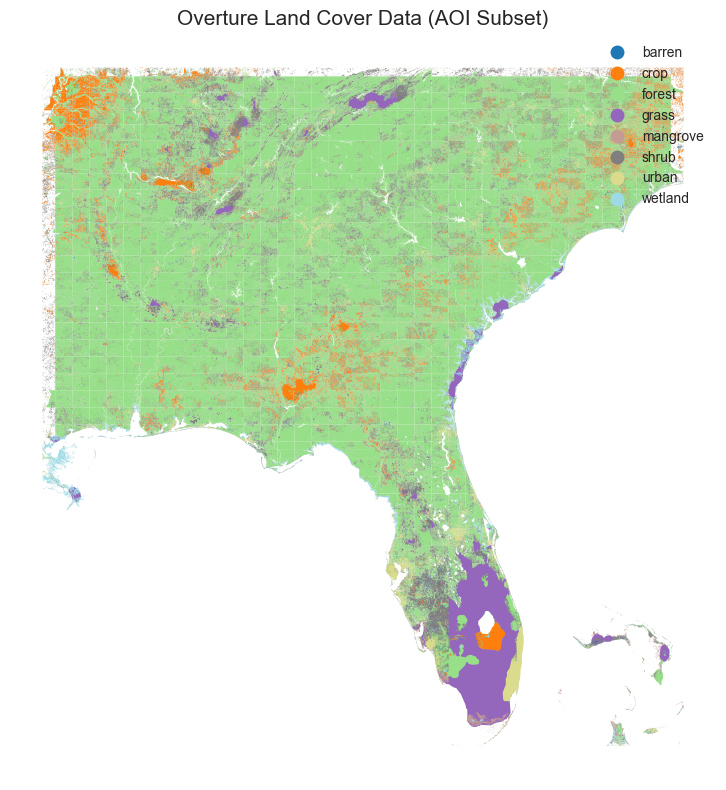

In [6]:
# Plot Land Cover Types
if not gdf.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot colored by 'subtype' (or 'class' if subtype is too granular)
    gdf.plot(
        column='subtype',
        legend=True,
        legend_kwds={'bbox_to_anchor': (1, 1)},
        cmap='tab20',
        ax=ax
    )
    
    ax.set_title("Overture Land Cover Data (AOI Subset)", fontsize=15)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## 4. Match with PV Dataset

We'll fetch a minimal subset of our PV dataset and overlay it to see the land cover context.

In [7]:
# PV Dataset URI
PV_DATA_URI = 'https://eo-pv-elt.work/geoparquet/ccom6994_pv_dataset.parquet'

def read_remote_parquet(url, bbox=None):
    print(f"Fetching PV data from {url}...")
    df = pd.read_parquet(url)
    
    # Convert geometry
    if 'geometry' in df.columns and df['geometry'].dtype == 'object':
        df['geometry'] = df['geometry'].apply(wkt.loads)
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    
    if bbox:
        print(f"Filtering to BBOX: {bbox}")
        gdf = gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        
    return gdf

# Fetch PV data (filtering to same AOI)
try:
    pv_gdf = read_remote_parquet(PV_DATA_URI, bbox=AOI_BBOX)
    print(f"Loaded {len(pv_gdf):,} PV installations.")
    
    # Simple overlay check (Spatial Join)
    # Find which land cover polygon each PV point falls into
    print("Performing Spatial Join...")
    
    # Ensure CRS match
    if pv_gdf.crs != gdf.crs:
        pv_gdf = pv_gdf.to_crs(gdf.crs)
        
    joined = gpd.sjoin(pv_gdf, gdf, how='left', predicate='within')
    
    # Show top land cover types for PV
    print("\nTop Land Cover Types for PV Installations:")
    print(joined['subtype'].value_counts().head(10))
    
except Exception as e:
    print(f"Error in PV matching: {e}")

Fetching PV data from https://eo-pv-elt.work/geoparquet/ccom6994_pv_dataset.parquet...
Filtering to BBOX: (-89.919, 24.7674, -76.7229, 36.7593)
Loaded 2,050 PV installations.
Performing Spatial Join...

Top Land Cover Types for PV Installations:
subtype
shrub     840
forest    343
urban     276
barren    203
crop       74
grass      68
Name: count, dtype: int64
